# POS Tagging con RNN

Analizaremos la estructura de una red recurrente simple. Nuestro objetivo será construir un modelo del lenguaje que tome como cadena de entrada una secuencia de palabras $w_1,...,w_T$ y cuya salida sean las etiquetas POS $s_1, ..., s_T$ que mejor describan la cadena de entrada. Para esto, buscaremos estimar la probabilidad:

$$p(s_1,...,s_T|w_1,....,w_T)$$


Para realizar esta probabilidad utilizaremos una arquitectura de red neuronal recurrente (RNN). En primer lugar definiremos algunas funciones para manejar el texto.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
from itertools import chain

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

### Procesamiento de corpus

Al igual que con modelos del lenguaje más tradicionales, tomamos un corpus e indexamos las palabras con valores numéricos, con el objetivo de que sea más fácil manejarlas.

Asimismo, contamos con una cadena de etiquetas POS, las cuáles corresponden a las clases de cada una de las oraciones de entrada; es decir, cada cadena de etiquetas le corresponde una cadena de palabras de la misma longitud. De igual forma, pasaremos las etiquetas a indices numéricos.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come']

#Etiquetas POS
tags = ['DA NC V DD NC', 'DD NC V', 'DA NC V DA NC', 'DD NC V NC', 'DA NC V', 'DA NC V NC', 'DD NC V']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

#Vocabulario de emisiones
ems = vocab()
#Se susituyen las emisiones por sus índices numéricos
ems_idx = list(text2numba(tags,ems))

print(cads_idx)
print(ems_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10], [0, 1, 2], [0, 11, 2, 10], [3, 11, 2]]
[[0, 1, 2, 3, 1], [3, 1, 2], [0, 1, 2, 0, 1], [3, 1, 2, 1], [0, 1, 2], [0, 1, 2, 1], [3, 1, 2]]


Una vez realizado esto, podemos crear los pares de entrenamiento. En este caso, simplemente alinearemos la cadena de palabras con sus etiquetas correspondientes.

In [3]:
#Pares de entrenamiento
pairs = [list(zip(a,b)) for a,b in zip(cads_idx,ems_idx)]
print(pairs)

[[(0, 0), (1, 1), (2, 2), (3, 3), (4, 1)], [(3, 3), (5, 1), (6, 2)], [(0, 0), (5, 1), (7, 2), (8, 0), (9, 1)], [(3, 3), (1, 1), (2, 2), (10, 1)], [(0, 0), (1, 1), (2, 2)], [(0, 0), (11, 1), (2, 2), (10, 1)], [(3, 3), (11, 1), (2, 2)]]


### Entrenamiento de la red

Para construir la red neuronal definiremos una arquitectura simple:

1) Incorporaremos una capa de embedding. En esta se tomará un one-hot $s^{(t)}$ que represente a una palabra $w_t$. Definiremos una matriz que guarde los vectores de embedding, $C$ de $d\times N$, donde $d$ es la dimensión de los embeddings y $N$ el tamaño del vocabulario. Así, la capa de embedding estará definida por $$x = Cs^{(t)}$$

2) Incorporaremos una celda que guarde los estados; esta celda tendra dimensión $m$. Está se definirá como $$h_t = \tanh(Vh_{t-1} + Ux + b)$$ Donde $h_{t-1}$ es la celda en el estado anterior, $V$ es una matriz de $m \times m$, $U$ una matriz de $d \times m$ y $b$ es el bias.

3) La capa de salida se conformará por la función Softmax. Así, la definimos como $$\phi(x) = Softmax(Wh_t + c)$$

En primer lugar, inicializamos los parámetros de la red.

In [4]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = len(idx)
#El total de clases que arrojará
output_dim = len(ems)

#Dimensiones de los vectores-palabra
dim = 2
cell_dim = 3

#Embedding
C = np.random.randn(dim,nn_input_dim) / np.sqrt(nn_input_dim)

#Capa oculta, estados anteriores
V = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)

#Capa oculta, entrada
U = np.random.randn(cell_dim,dim) / np.sqrt(dim)
b = np.zeros(cell_dim)

#Capa de salida
W = np.random.randn(output_dim,cell_dim) / np.sqrt(cell_dim)
c = np.zeros(output_dim)

A continuación, definimos el entrenamiento: la fase de forward y el backpropagation. Utilizamos un rango de aprendizaje (lr) de 0.1 y 100 iteraciones (it).

In [5]:
it = 100
lr = 0.1

for t in range(it):
        
    for seq in pairs:
        #Inicializaciopn de estados
        h = np.zeros((len(seq)+1,cell_dim))

        for t,w in enumerate(seq):
            #FORWARD
            #Embedding
            x = C.T[w[0]]
            
            #Unidad oculta
            act = np.dot(V,h[t]) + np.dot(U,x) + b
            h[t+1] = np.tanh(act)

            #capa de salida
            preAct = np.exp(np.dot(W,h[t+1]) + c)
            #Softmax
            probs = preAct/preAct.sum(0)
            
            #BACK-PROP
            #Variable de salida
            d_out = probs
            d_out[w[1]] -= 1
            
            #Variable de celdas
            d_h = (1-h[t+1]**2)*np.dot(W.T,d_out)
            #Variable de embedding
            d_emb = np.dot(U.T,d_h)

            #Jacobianas
            dW = np.outer(d_out,h[t+1])
            dV = np.outer(d_h, h[t])
            dU = np.outer(d_h, x)

            #Gradientes descendientes
            W -= lr*dW
            c -= lr*d_out
            
            V -= lr*dV
            
            U -= lr*dU
            b -= lr*d_h
            
            C.T[w[0]] -= lr*d_emb

### Predicción de etiquetas POS

Una vez entrenado el modelo, definimos una función (forward) que corra la red sobre una cadena de entrada. Esta función devolverá la probabilidad de las etiquetas POS en cada estado y dado la palabra de entrada en ese estado.

In [6]:
def forward(sent, h = np.zeros(cell_dim)):
    sent = sent.split()
    prob_tot = np.zeros((len(sent),output_dim))
    
    for t,w in enumerate(sent):
        #FORWARD
        #embedding
        x= C.T[idx[w]]
        #Unidad oculta
        act = np.dot(V,h) + np.dot(U,x) + b
        h = np.tanh(act)

        #capa de salida
        preAct = np.exp(np.dot(W,h) + c)
        probs = preAct/preAct.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = probs
        
    return h, prob_tot       

Dado que la RNN guarda información de los estados anteriores, podemos obtener la cadena de etiquetas POS a partir de escoger la etiqueta que maximice la probabilidad en cada estado. Esto es:

$$\hat{s_t} = \arg\max_s p(s|s_1,...,s_{t-1},w_1,...,w_t)$$

In [7]:
#Vocabulario para recuperar POS por medio de índices
post = {v:k for k,v in ems.items()}

#Forwarde de la red
H,p = forward('el gato come la cuerda')

#Buscamos las etiquetas que maximicen la probabilidad
print([post[i] for i in np.argmax(p, axis=1)])

['DA', 'NC', 'V', 'DA', 'NC']


### Ploteo de los embeddings

Además de obtener una probabilidad de cadenas, el modelo que hemos descrito aprende representaciones vectoriales de la palabra o embeddings. Al igual que el modelo de Word2Vec, podemos ocupar una arquitectura recurrente para obtener embeddings de palabra. Aquí hemos descrito una versión muy sencilla de esto. Modelos más complejos son CoVe (McCann, 2017) o ELMo (Peters et al., 2018).

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from operator import itemgetter

#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    #plt.show()

#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]

Así, la visualización de los datos es la siguiente:

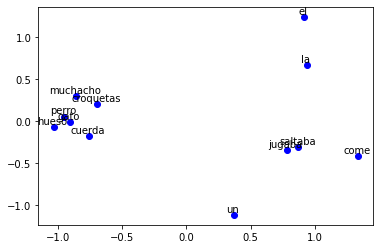

In [9]:
plot_words(C.T,label)
plt.show()

### Calculo de similitud

Para calcular la similitud entre vectores, se puede utilizar la distancia eculideana o bien el coseno. En NLP el coseno es una forma común de determinar la similitud entre vectores. Este se define como:

$$\cos(x,y) = \frac{x\cdot y}{||x|| ||y||}$$

Asimismo, para simplificar el calculo del coseno se pueden normalizar los vectores, dividiéndolos entre sus normas. Así, para cada vector $x$ su norma es $||x||=1$, lo que simplifica la ecuación anterior a:

$$\cos(x,y) = x\cdot y$$

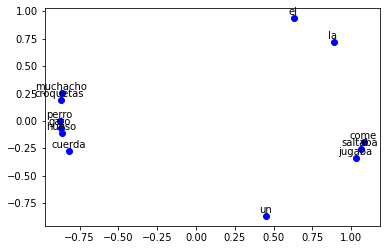

In [10]:
#Normalización de los vecotores
C_norm = (C/np.array([np.linalg.norm(w) for w in C.T])).T

#Ploteo
plot_words(C_norm,label)

In [11]:
#Palabra objetivo
obj_word = C_norm[idx['perro']]

#Búsqueda de palabras más similares
for w,v in idx.items():
    #Calcula la distancia coseno
    print(w,'\t', np.dot(C_norm[v], obj_word) )

el 	 -0.5801734454322444
perro 	 0.9999999999999998
come 	 -0.9396770892436934
un 	 -0.2557643936508411
hueso 	 0.9938145151842602
muchacho 	 0.9664225283410175
jugaba 	 -0.8743056236180435
saltaba 	 -0.9129990146524548
la 	 -0.8150435832538478
cuerda 	 0.9615611659937237
croquetas 	 0.9805771102767834
gato 	 0.9980801362784861


### Visualización de las celdas recurrentes

Las celdas recurrentes guardan información tanto de los vectores de entrada como de la red en estados anteriores. Estas celdas tienen información importante que le permite a la red decidir la distribución de salida en un estado dado. Algunos modelos de representación vectorial (word embeddings) han aprovechado la información aquí almacenada para producir vectores de palabraS; sistemas como CoVe toman en cuenta estas celdas para "contextualizar" los embeddings.

Lo primero que haremos es definir un función que, además de devolver la probabilidad de salida, regrese cada una de las celdas recursivas en cada estado $t$. Así, obtendremos una matriz $H$ donde cada renglon será una celda vanilla. Podemos definir esta matriz por sus renglones como:

$$H_{t} = g(Vh^{(t-1)} + Ux^{(t)} + b)$$

In [12]:
def get_cells(sent, h = np.zeros(cell_dim)):
    sent = sent.split()
    prob_tot = np.zeros((len(sent),output_dim))
    H = np.zeros((len(sent), cell_dim))
    
    for t,w in enumerate(sent):
        #FORWARD
        #embedding
        x= C.T[idx[w]]
        #Unidad oculta
        act = np.dot(V,h) + np.dot(U,x) + b
        h = np.tanh(act)
        #add h
        H[t] = h

        #capa de salida
        preAct = np.exp(np.dot(W,h) + c)
        probs = preAct/preAct.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = probs
        
    return H, prob_tot 

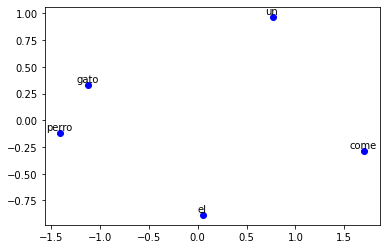

In [13]:
ex_sent = 'el perro come un gato'
H_s, p_s = get_cells(ex_sent)

plot_words(H_s,ex_sent.split())

In [14]:
#Etiqueta POS
print([post[i] for i in np.argmax(p_s,axis=1)])

['DA', 'NC', 'V', 'DD', 'NC']


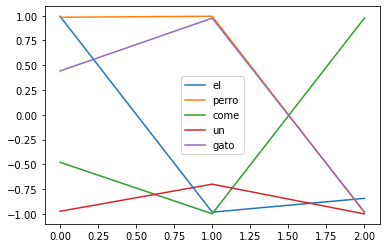

[[ 0.99376902 -0.98177349 -0.84289654]
 [ 0.98440517  0.99465852 -0.98594426]
 [-0.47850694 -0.99812281  0.9761792 ]
 [-0.97313577 -0.69946964 -0.99956026]
 [ 0.44242013  0.97549661 -0.97863646]]


In [15]:
plt.plot(H_s.T, '-')
plt.gca().legend(ex_sent.split())
plt.show()
print(H_s)